# Кластеризация методом k-means

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

## Постановка задачи
Даны точки: $X=\{x_1, \ x_2, \ \ldots, \ x_m\}\subset\mathbb{R}^n$. Распределить их по группам (**кластерам**) с помощью алгоритма k ближайших соседей (**k-means**).

In [3]:
n_points = 2000
n_features = 2
X, tags = make_blobs(n_samples=n_points, n_features=n_features, centers=3, random_state=0)

## В двух словах
1. Определить число $k$ – оптимальное число кластеров;
2. Инициализировать точки $M=\{\mu_1, \ \mu_2, \ \ldots, \ \mu_k\}$ – центры кластеров (**центроиды**);
3. Решить итеративным алгоритмом

## Подробный алгоритм
### Инициализация центроидов
Пока считаем, что число кластеров известно:

In [4]:
n_clusters = 3

#### Случайные точки области
**Идея**: выберем случайные точки из области $G\subset\mathbb{R}^n$, которая содержит все точки из $X$

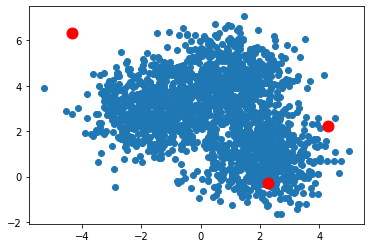

In [8]:
def init_random():
    global centroids
    min_coords = np.min(X, axis=0)
    max_coords = np.max(X, axis=0)

    coords = np.zeros((n_features, n_clusters))
    for i in range(n_features):
        coords[i] = np.random.rand(n_clusters) * (max_coords[i] - min_coords[i]) + min_coords[i]

    centroids = coords.T

init_random()
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

#### Случайная выборка
**Идея**: создадим случайную выборку длины $k$ из точек массива $X$

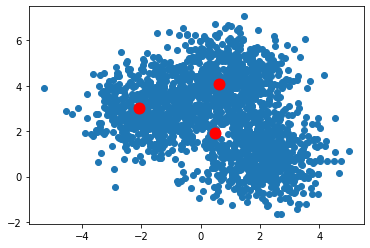

In [13]:
def init_sample():
    global centroids, indeces
    indeces = np.random.choice(np.arange(X.shape[0]), n_clusters, replace=False)
    centroids = np.copy(X[indeces])

init_sample()
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

#### Наиболее удалённые точки
**Идея**:
- первую точку выберем среди точек $X$
- вторую точку найдём как наиболее удалённую от первой
- третью точку найдём как наиболее удалённую от первой и второй точек
- и так далее

Для этого нужно на каждом шаге $i$ считать расстояния от точек $X$ до уже построенных центроидов $\mu_1, \ \ldots, \ \mu_{i-1}$

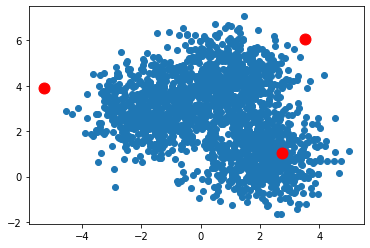

In [12]:
def compute_distance_matrix(centr_ind):             
    result = np.zeros((n_points, centr_ind))
    
    for i in range(0, n_points):
        for j in range(0, centr_ind):
            result[i][j] = np.linalg.norm(centroids[j] - X[i])
    return result

def init_distant():
    global centroids, indeces
    indeces = np.zeros(n_clusters, dtype=int)
    centroids = np.zeros((n_clusters, n_features))

    t = np.random.randint(0, n_points, size=1)
    indeces[0] = t
    centroids[0] = X[t]

    for i in range(1, n_clusters):
        t = np.argmax(compute_distance_matrix(i).mean(axis=1))
        indeces[i] = t
        centroids[i] = X[t]

init_distant()
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

#### В одну функцию

In [14]:
def init_centr(heur):
        dct = {
            "sample": init_sample,
            "random": init_random,
            "distant": init_distant,
        }
        dct[heur]()

### Установка тегов кластера
Дальше нужно распределить точки массива $X$ по кластерам $C_1, \ C_2, \ \ldots, C_k$. Точка относится к тому кластеру, чей центр ей ближе:
$$C_i=\{x\in X: \|x-\mu_i\|=\min\limits_{\mu} \|x-\mu\|\}$$
Значит, нужно определять для каждого $x\in X$, какой центр ближе

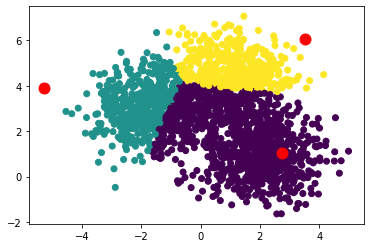

In [13]:
def near_center(point):
    result = 0
    for i in range(n_clusters):
        if np.linalg.norm(point - centroids[i]) < np.linalg.norm(point - centroids[result]):
            result = i
    return result

labels = np.zeros(n_points)
def set_labels():
    global labels
    for i in range(n_points):
        labels[i] = near_center(X[i])

set_labels()

plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

### Итеративный алгоритм
Алгоритм называется итеративным, если он находит решение задачи как предел некоторой последовательности. 
Каждая итерация k-means состоит из двух шагов:

1. **Assignment**. Приписать каждый объект к ближайшему центру;
2. **Update**. Пересчитать центроиды как центры масс кластеров, полученых на шаге assignment.
Алгоритм прерывают тогда, когда достигнута заранее установленная точность. Поскольку массив центроидов – это матрица $k\times n$, то мы прервём алгоритм когда выполнится условие:
$$\|M_n-M_{n+1}\|_F\leqslant\varepsilon,$$
где $\|\cdot\|_F$ – норма Фробениуса

In [16]:
def update_centers():
    global centroids
    centroids = np.zeros((n_clusters, n_features))
    for i in range(n_clusters):
        centroids[i] = X[labels == i].mean(axis=0)
    return centroids

def perform(heur='sample', prec=0.001):
        init_centr(heur)
        set_labels()

        while (np.linalg.norm(centroids - update_centers()) > prec):
            set_labels()
        
        # distances = compute_distance_matrix(n_clusters)
        # compute_SSW()
        # save_config()

In [17]:
perform()

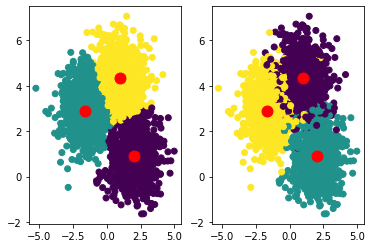

In [18]:
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=tags)
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

## Выбор лучшего решения
k-means чувствителен к начальной инициализации: если два начальных центроида окажутся в области точек, изолированных от других, то решение почти гарантированно будет неверным.
Поэтому будем прогонять алгоритм `n_start` раз и затем выбирать лучший ответ.
Заодно добавим "апгрейд": сортировку точек массива $X$ по кластерам

### Самое частое решение
Среди всех вычисленных конфигураций найдём ту, которая отлична от других меньше всего.

#### Недостатки
При увеличении числа кластеров или при использовании эвристики `random` (об этом позже) это улучшение слабо помогает. Лучше всего его использовать при малом числе кластеров и с эффективной эвристикой `simple` (об этом позже).

### Sum of Squares Within
Для каждого кластера посчитаем сумму квадратов отклонений каждой точки от своего центра, т.е.
$$SSW_{i}= \sum_{j=1}^{|C_i|} \|x_j-\mu_i\|^2$$
Затем сложим все суммы. Полученное число будет мерой совокупной однородности кластеров: чем оно меньше, тем однороднее кластеры. (см. в конечной реализации)

## Класс `KMeans`

In [14]:
class KMeans:
    def __init__(self, X, n_clusters, n_features):
        """
        X is array of points (x, y)
        """

        self.X = X
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_points = X.shape[0]
    
    def init_random(self):
        """
        initializes array of centroids using 'random' strategy:
        random points from the area of X
        """

        min_coords = np.min(self.X, axis=0)
        max_coords = np.max(self.X, axis=0)

        coords = np.zeros((self.n_features, self.n_clusters))
        for i in range(self.n_features):
            coords[i] = np.random.rand(self.n_clusters) * (max_coords[i] - min_coords[i]) + min_coords[i]

        self.centroids = coords.T

    def init_sample(self):
        """
        initializes array of centroids using 'sample' strategy:
        random simple sample from X
        """

        self.indeces = np.random.choice(np.arange(self.X.shape[0]), self.n_clusters, replace=False)
        self.centroids = np.copy(self.X[self.indeces])
    
    def compute_distance_matrix(self, centr_ind):   
        """
        высчитывает и возвращает матрицу расстояний от всех точек до центроидов,
        построенных 'centr_int-1` центроидов.
        нужно для реализации `distant`-стратегии инициализации центроидов
        """     
        res = np.zeros((self.n_points, centr_ind))
        for i in range(0, self.n_points):
            for j in range(0, centr_ind):
                res[i][j] = np.linalg.norm(self.centroids[j] - self.X[i])
        return res

    def init_distant(self):
        """
        initializes array of centroids using 'distant' strategy:
        1st centroid is random point of X, 2nd is the farthest point of X from 1st centroid,
        3rd is the farthest point of X from 1st ans 2nd centroids etc.
        """
        self.indeces = np.zeros(self.n_clusters, dtype=int)
        self.centroids = np.zeros((self.n_clusters, self.n_features))

        t = np.random.randint(0, self.n_points, size=1)
        self.indeces[0] = t
        self.centroids[0] = self.X[t]

        for i in range(1, self.n_clusters):
            t = np.argmax(self.compute_distance_matrix(i).mean(axis=1))
            self.indeces[i] = t
            self.centroids[i] = self.X[t]

    def init_centr(self, heur):
        """
        initializes centroids by given heuristic
        """
        dct = {
            "sample": self.init_sample,
            "random": self.init_random,
            "distant": self.init_distant,
        }
        dct[heur]()
    
    def near_center(self, point):
        """
        returns the index of the nearest centroid from given point
        """
        res = 0
        for i in range(self.n_clusters):
            if np.linalg.norm(point - self.centroids[i]) < np.linalg.norm(point - self.centroids[res]):
                res = i
        return res

    def set_labels(self):
        """
        marks points from X in accordance with which centroid is closer
        """
        self.labels = np.zeros(self.n_points)
        for i in range(self.n_points):
            self.labels[i] = self.near_center(self.X[i])  

    def update_centers(self):
        """
        updates centroids for every cluster
        """
        self.centroids = np.zeros((self.n_clusters, self.n_features))
        for i in range(self.n_clusters):
            self.centroids[i] = self.X[self.labels == i].mean(axis=0)
        return self.centroids
    
    def perform(self, heur, prec):
        """
        iterative k-means algorithm
        """
        self.init_centr(heur)
        self.set_labels()

        while(np.linalg.norm(self.centroids - self.update_centers()) > prec):
            self.set_labels()
        
        self.compute_SSW()  # чтобы потом сравнить
        self.save_config()  # с другими конфигурациями

        return self
    
    def save_config(self):
        """
        saves centroids, labels, X and SSW to 'configs' attribute
        """
        self.configs.append([self.centroids, self.labels, self.X, self.SSW])
    
    def sort_points(self):
        """
        sorts points of X by cluster labels
        """
        together = np.hstack([self.labels.T.reshape((self.n_points, 1)), self.X])
        together = sorted(together, key=lambda x: x[0])
        
        self.X = np.array(together)[:, 1:]
        self.labels = np.array(together)[:, 0]
    
    def compute_SSW(self):
        """
        computes SSW for current cluster configuration
        """
        cluster_squares = self.compute_distance_matrix(self.n_clusters) ** 2

        within_cluster_squares = np.zeros(self.n_clusters)
        for i in range(self.n_clusters):
                within_cluster_squares[i] = np.sum(cluster_squares[self.labels == i], axis=0)[i]

        self.SSW = np.sum(within_cluster_squares)
    
    def find_best(self, n_start):
        """
        finds the best cluster configuration by SSW
        """
        SSW_values = np.zeros(n_start)
        for i in range(n_start):
            SSW_values[i] = self.configs[i][3]
        
        return self.configs[np.argmin(SSW_values)]

    def fit(self, heur="sample", n_start=3, prec=0.001):
        """
        main function that performs iterative k-means algorithm and finds the best configuration
        """
        self.configs = []
        for i in range(n_start):
            self.perform(heur, prec)
        
        best_config = self.find_best(n_start)
        self.centroids = best_config[0]
        self.labels = best_config[1]
        self.X = best_config[2]
        self.sort_points()
        self.distances = self.compute_distance_matrix(self.n_clusters)

        return self

## Выбор числа кластеров
Будем находить оптимальное число кластеров **методом локтя** (*elbow method*): прогоним алгоритм на одних и тех же данных, указывая разные количества кластеров, и построим график $SSW$. Число кластеров, при котором график превращается в почти горизонтальный и будет оптимальным

In [15]:
class elbow:
    """
    the way to find optimal clusters count
    """
    def __init__(self, X, n_features, heur='sample', kmax=10, n_start=3):
        self.kmax = kmax
        self.variances_for_k = np.zeros(kmax)
        self.models = []
        for k in range(kmax):
            m = KMeans(X, n_clusters=k+1, n_features=n_features).fit(heur=heur, n_start=n_start)
            self.variances_for_k[k] = m.SSW
            self.models.append(m)
        
    def choose_k(self):
        """
        looks through the values of SSW to find optimal count.
        perfectly works with gaussian blobs
        """
        diffrences = np.zeros(self.kmax)
        for k in range(1, self.kmax):
            diffrences[k] = self.variances_for_k[k - 1] - self.variances_for_k[k]
        
        proportions = np.zeros(self.kmax)
        for k in range(1, self.kmax):
            proportions[k] = diffrences[k] / self.variances_for_k[k]
        
        
        return np.argmin(proportions[1:]) + 1

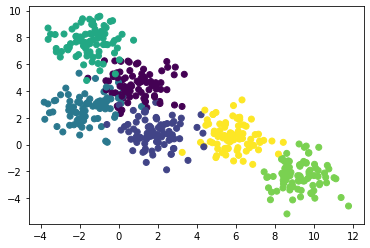

In [20]:
X, tags = make_blobs(n_samples=500, n_features=2, centers=6, random_state=0)
solve = elbow(X, n_features=2, kmax=7)
plt.scatter(X[:, 0], X[:, 1], c=tags)

optimal cluster count is 6


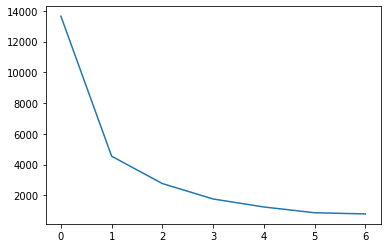

In [21]:
plt.plot(solve.variances_for_k)
print(f"optimal cluster count is {solve.choose_k()}")